In [2]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-02-01  367.450012  368.140015  360.880005  365.109985  364.988892   
2021-02-02  366.170013  379.730011  366.170013  375.119995  374.995575   
2021-02-03  376.230011  377.760010  373.220001  375.440002  375.315460   
2021-02-04  378.429993  386.190002  376.679993  384.109985  383.982605   
2021-02-05  386.899994  391.959991  384.579987  386.970001  386.841675   

            Volume     Date  
Date                         
2021-02-01  210700  18659.0  
2021-02-02  355100  18660.0  
2021-02-03  160800  18661.0  
2021-02-04  304600  18662.0  
2021-02-05  293500  18663.0  
               Date        Open        High         Low       Close
Date                                                               
2021-02-01  18659.0  367.450012  368.140015  360.880005  365.10998

/Users/jason/Work/Cinnamon/Code/Personal/CryptoPricePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


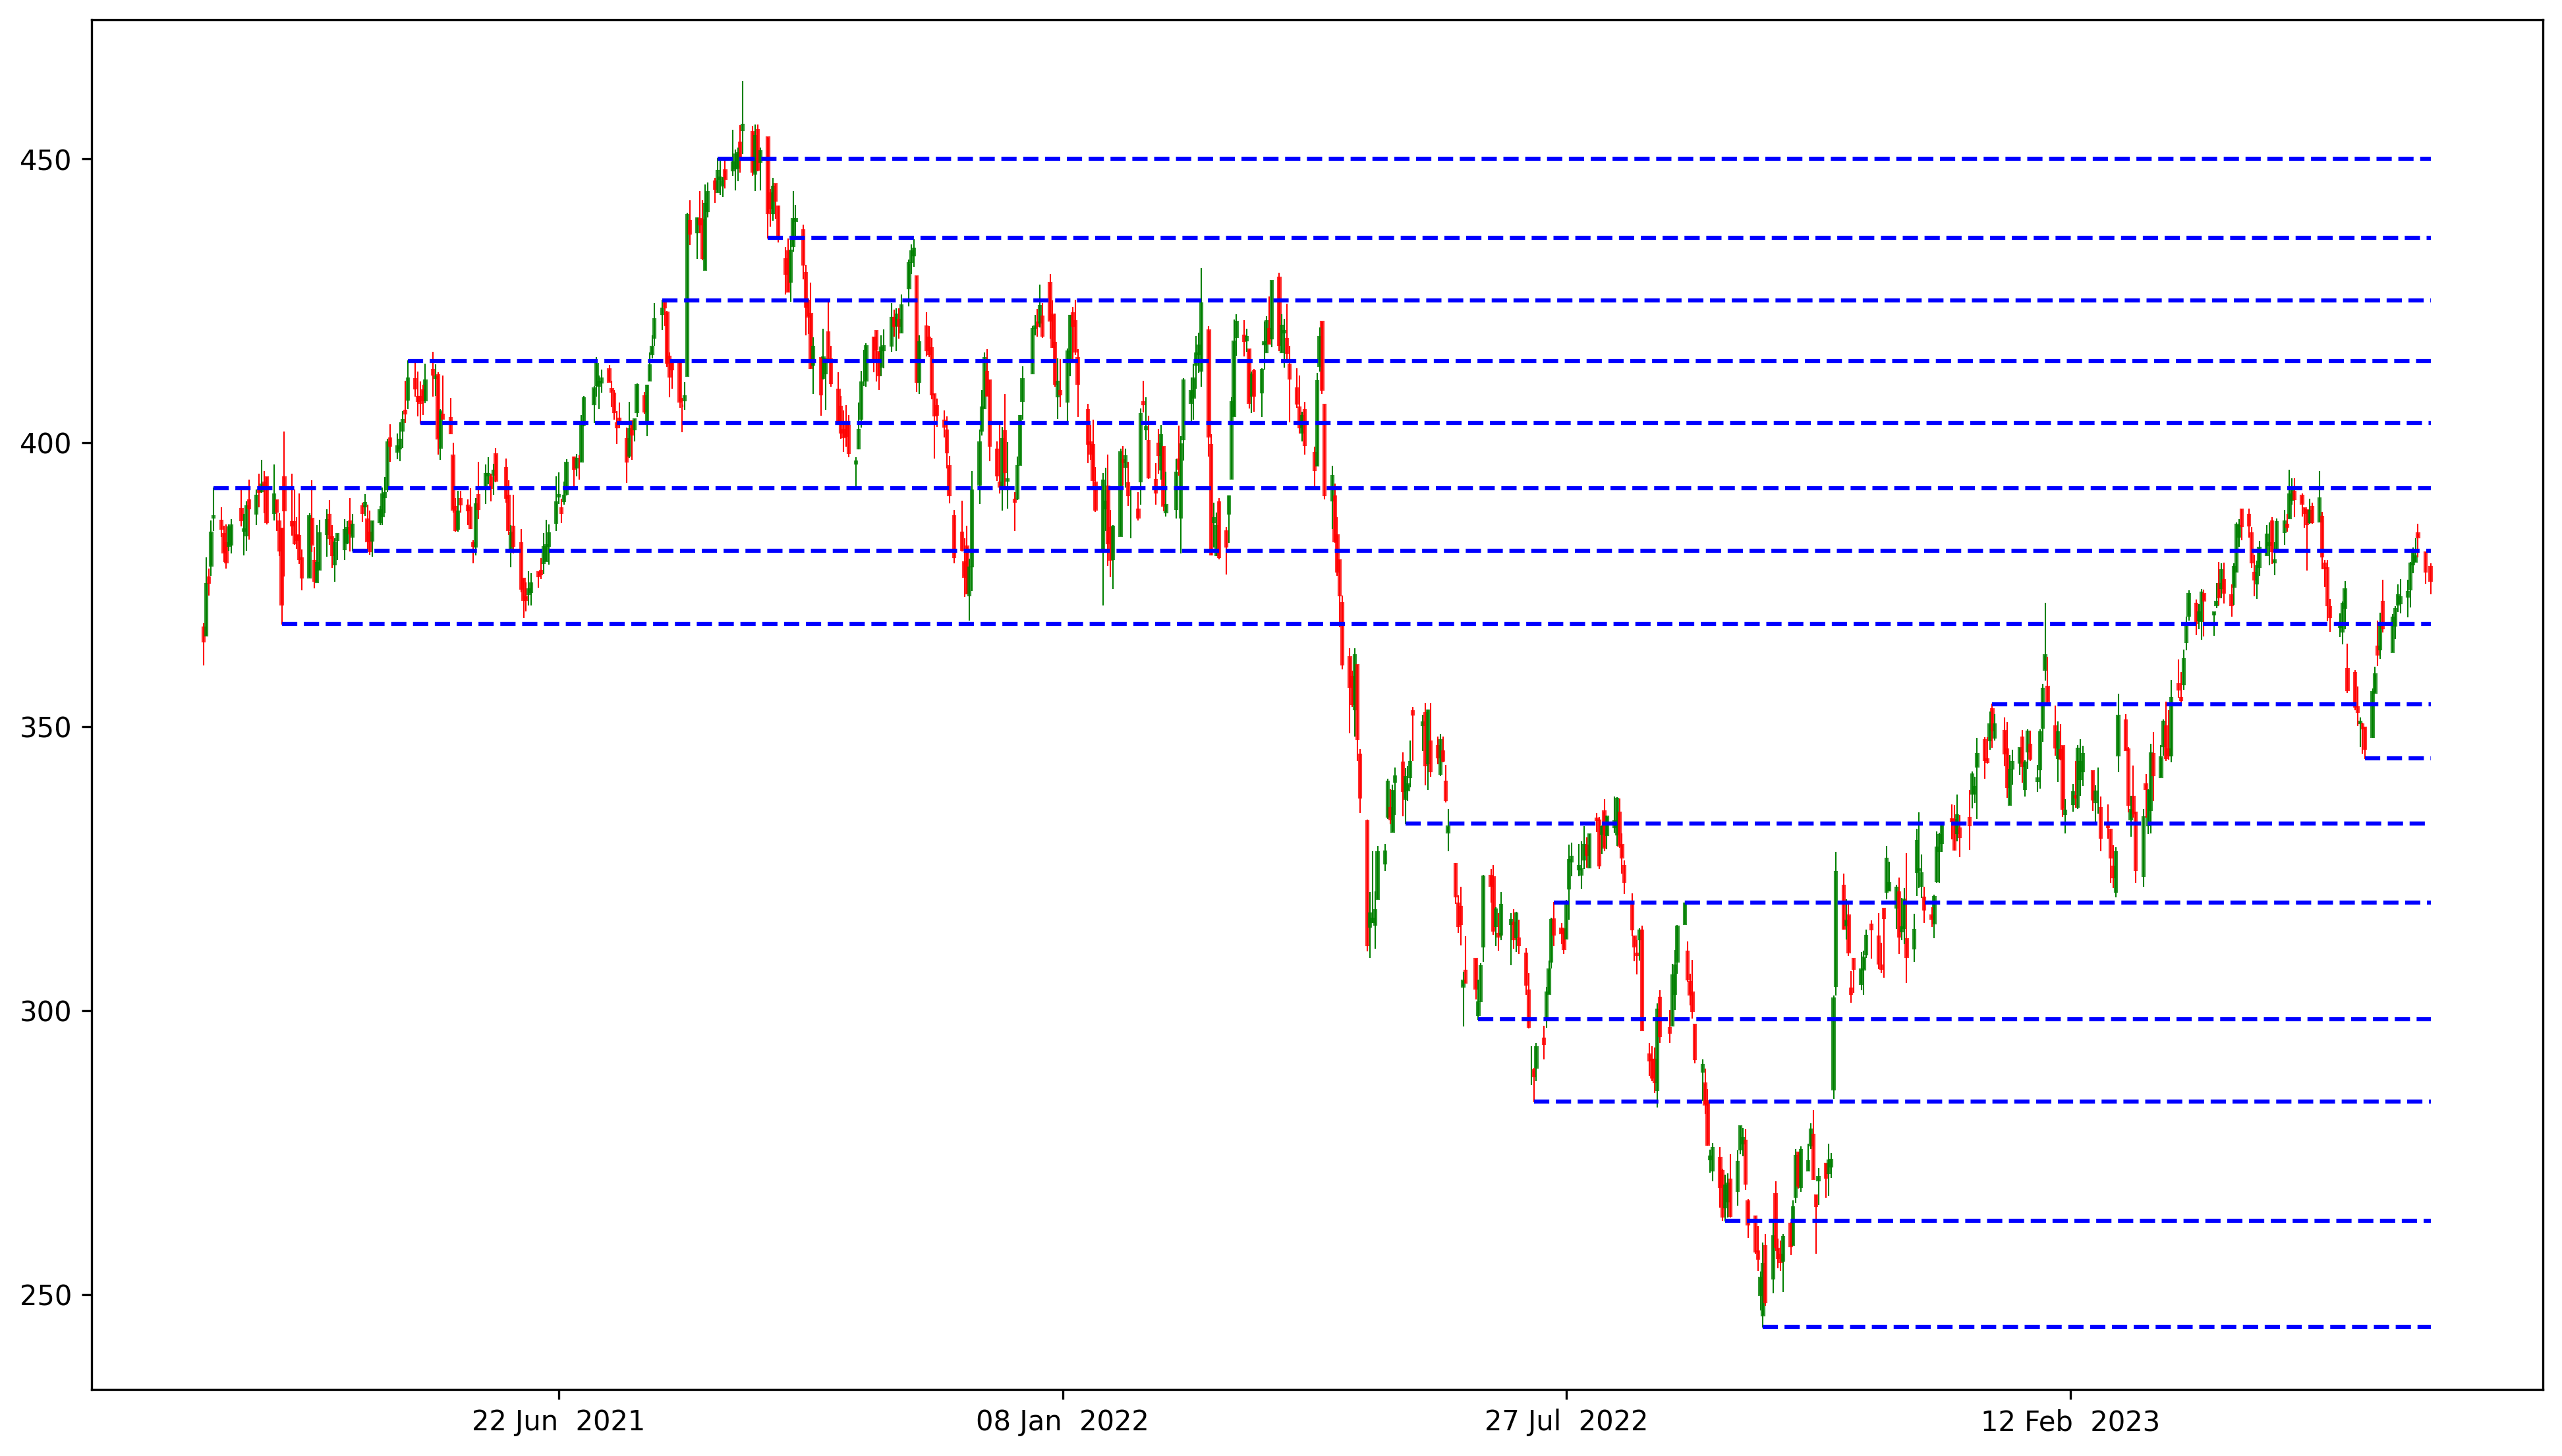

In [5]:
# method 1: fractal candlestick pattern

def get_stock_price(symbol):
  df = yf.download(symbol, start='2021-02-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  print(df.head())

  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  print(df.head())

  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b  %Y')
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--')
    fig.show()

stock_code = 'COO'
df = get_stock_price(stock_code)
levels = []
for i in range(2,len(df)-2):
  if is_support(df,i):
    l = df['Low'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))
  elif is_resistance(df,i):
    l = df['High'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))

plot_all(levels, df)

In [7]:
df.head()

,Date,Open,High,Low,Close
Date,,,,,
2021-02-01,18659.0,367.450012,368.140015,360.880005,365.109985
2021-02-02,18660.0,366.170013,379.730011,366.170013,375.119995
2021-02-03,18661.0,376.230011,377.760010,373.220001,375.440002
2021-02-04,18662.0,378.429993,386.190002,376.679993,384.109985
2021-02-05,18663.0,386.899994,391.959991,384.579987,386.970001


[*********************100%***********************]  1 of 1 completed


/Users/jason/Work/Cinnamon/Code/Personal/CryptoPricePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


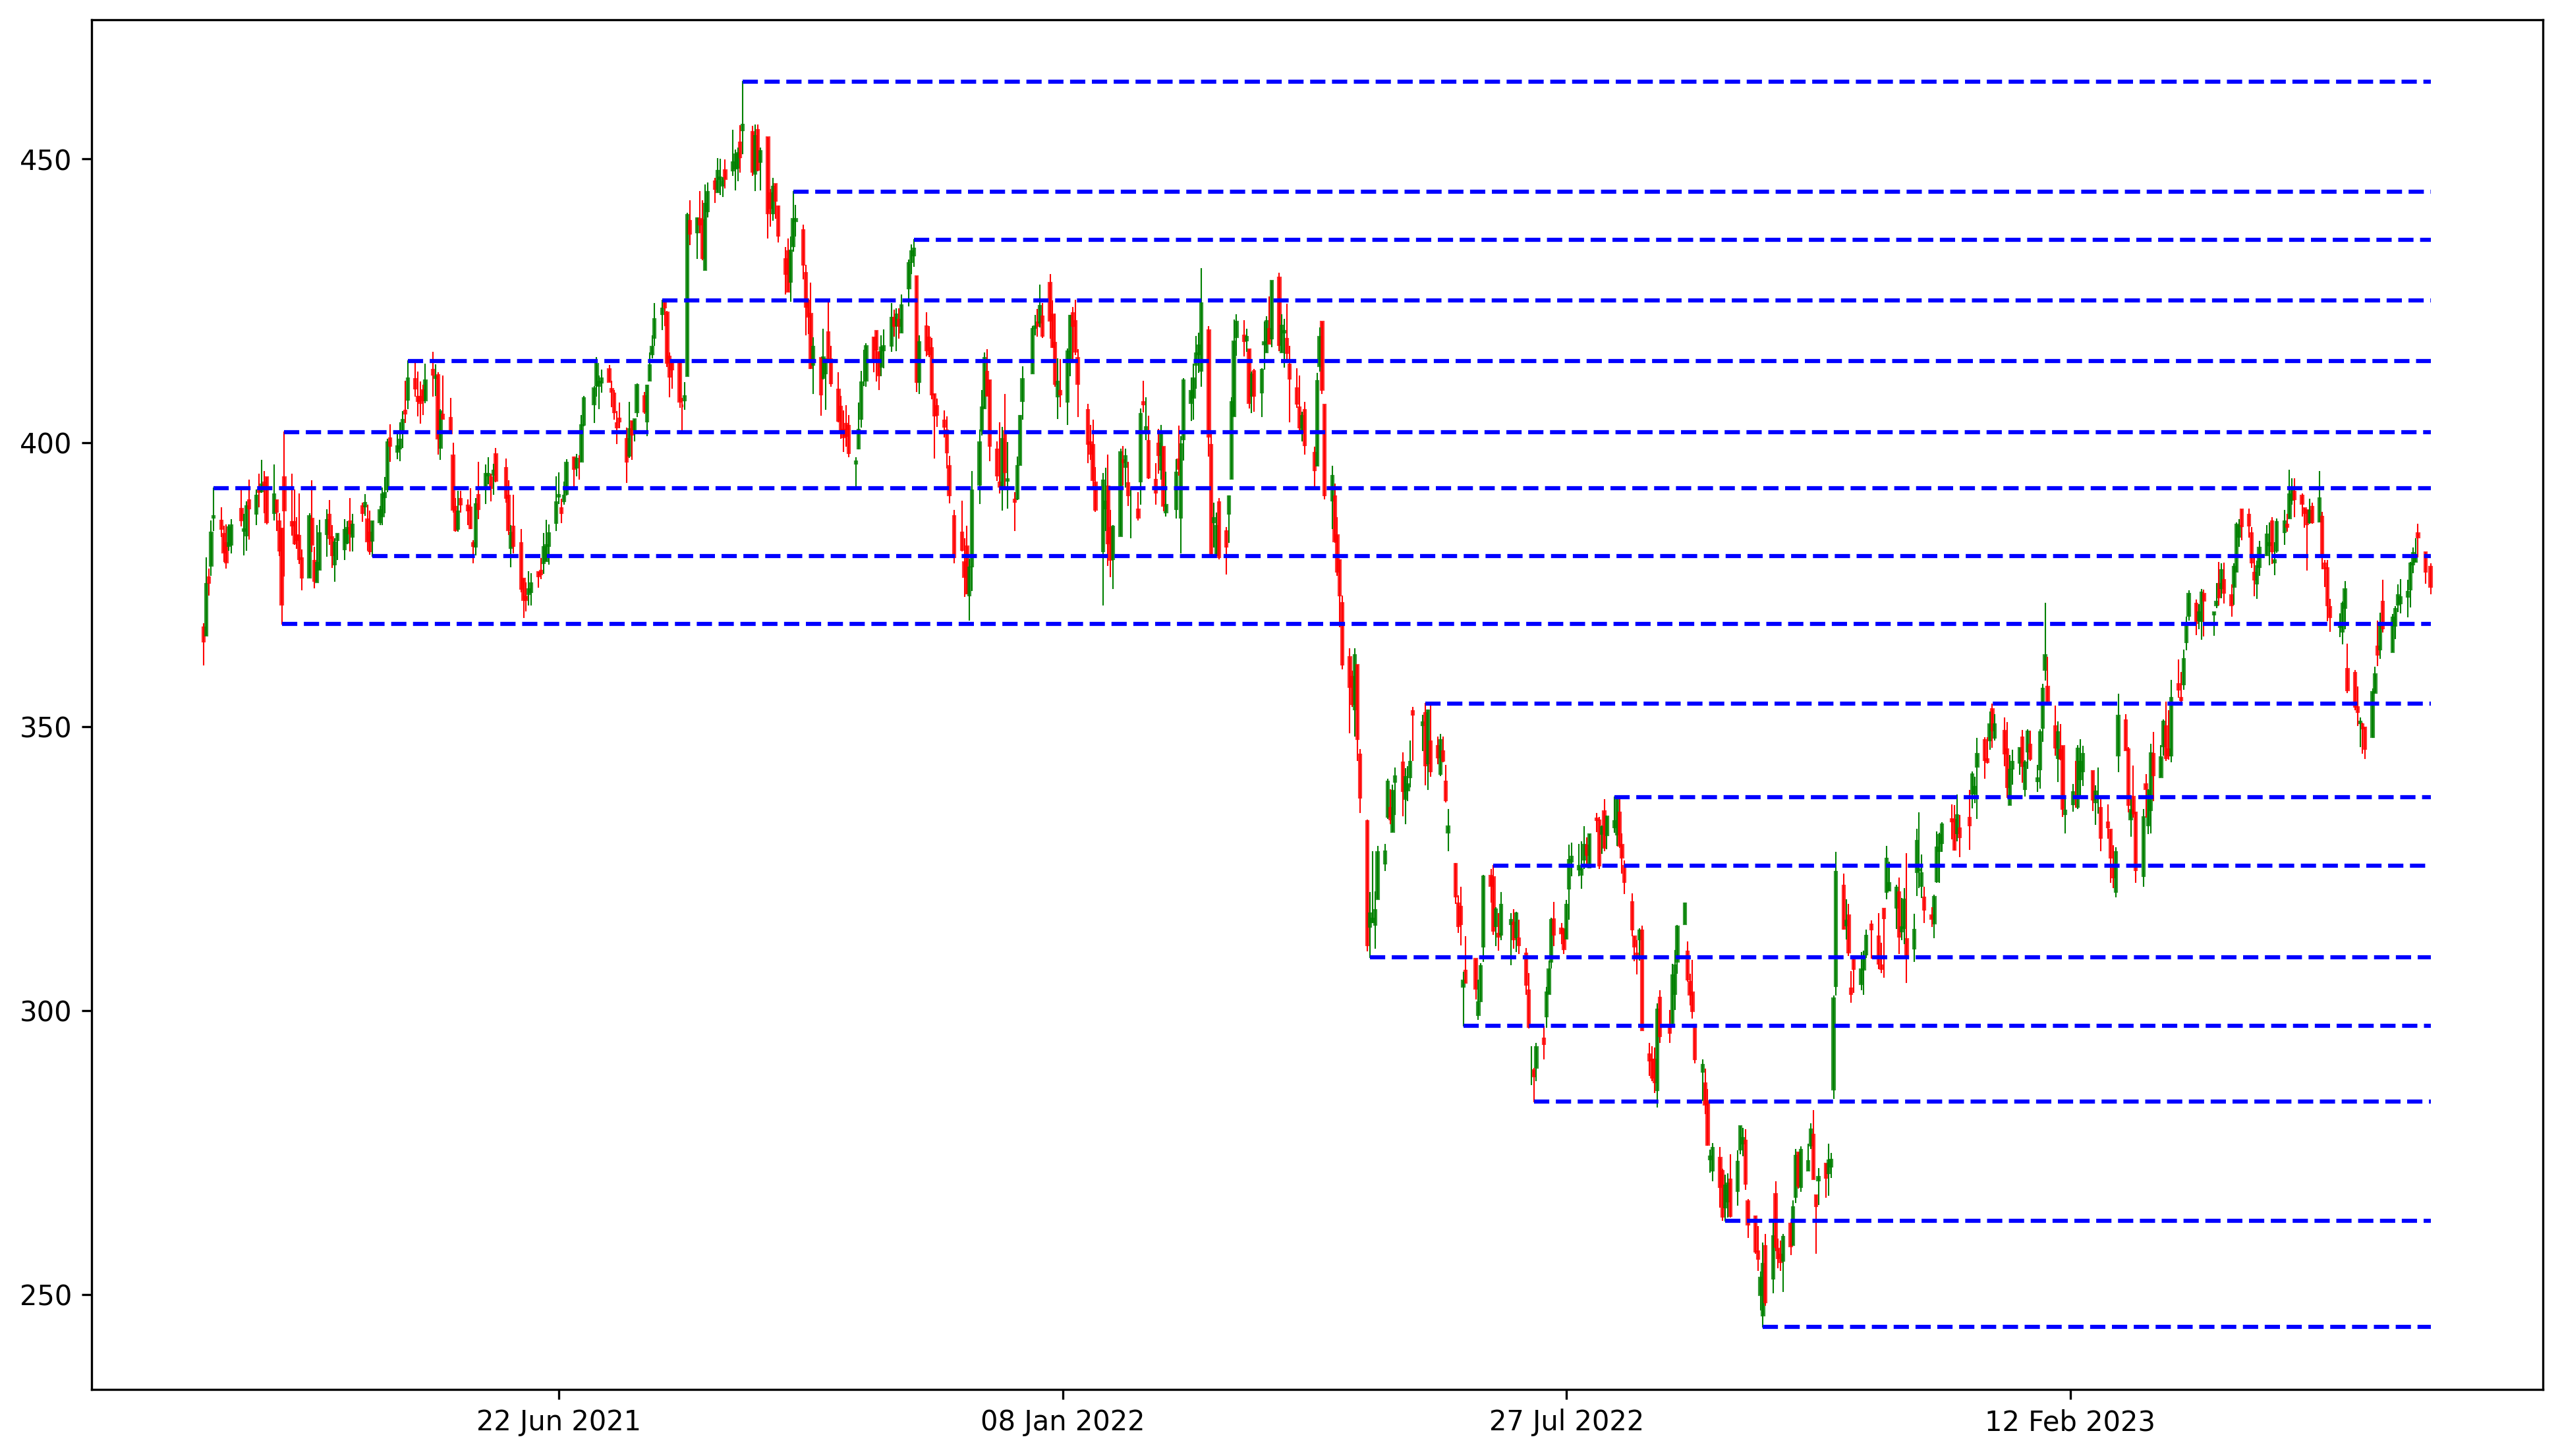

In [5]:
#method 2: window shifting method
symbol = 'COO'
df = get_stock_price(symbol)

pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
    high_range = df['High'][i-5:i+4]
    current_max = high_range.max()

    if current_max not in max_list:
        max_list = []
    max_list.append(current_max)
    if len(max_list) == 5 and is_far_from_level(current_max, pivots, df):
        pivots.append((high_range.idxmax(), current_max))
    
    low_range = df['Low'][i-5:i+5]
    current_min = low_range.min()
    if current_min not in min_list:
        min_list = []
    min_list.append(current_min)
    if len(min_list) == 5 and is_far_from_level(current_min, pivots, df):
        pivots.append((low_range.idxmin(), current_min))

plot_all(pivots, df)     